# Prevendo o El Niño - Oscilação do Sul

##### Autora: Luciana Nogueira de Paula Souza

\
\
O foco deste projeto é o fenômeno El Niño-Oscilação do Sul. Considerando que esse fenômeno possui uma frequência irregular e ainda não é totalmente compreendido, o objetivo é utilizar modelos de Machine Learning para tentar prever os eventos futuros do fenômeno. Também nesse estudo, trabalho com a hipótese da atividade solar ser um possível fator para essa oscilação, comparando os modelos com e sem a presença dessa variável e avaliando os resultados das modelagens. 

## Introdução

O fenômeno do El Niño é monitorado por várias medições no Oceano Pacífico: temperatura do oceano, pressão atmosférica, velocidade e direção dos ventos, sendo a principal medida a temperatura na superfície do oceano na região 3.4 do Pacífico, chamada de Niño 3.4 SST Index. Essa medida representa a média da variação da temperatura nessa região durante os últimos 3 meses, sendo considerado El Niño um fenômeno presente caso esse valor seja maior que 0.5 &deg;C, e caso seja inferior a -0.5 &deg;C o índice aponta a presença da La Niña.

Os registros mensais desde 1950 foram obtidos nos arquivos do NOAA/National Weather Service, através da página https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml, onde se disponibilizam algumas bases de dados ao público.

A atividade solar é determinada pelas manchas solares. Os ciclos solares têm duração de aproximadamente 11 anos e são medidos pelo número de manchas solares observadas, sendo o pico da atividade o período onde é observado o maior número de manchas solares. Os dados da atividade solar são representados pela média mensal do número de manchas ativas, e foram obtidos no banco de dados do Royal Observatory of Belgium, através da página https://www.sidc.be/SILSO/datafiles. 


| Variável      | Descrição                      |
|---------------|--------------------------------|
| Y             | Ano                            |
| MON           | Mês                            |
| YR_dec        | Ano decimal                    |
| TOTAL         | Temperatura medida             |
| ClimAdjust    | Temperatura referência         |
| ANOM          | Anomalia= TOTAL-ClimAdjust     |
| spot_avg      | Número médio de manchas solares|


O objetivo principal é encontrar uma boa modelagem em cima desses dados, para viabilizar a previsão do fenômeno através do Machine Learning. O objetivo secundário desse estudo é avaliar a hipótese de que a atividade solar permita um melhor ajuste ao modelo, mostrando-se um fator importante na previsão. 

## Análise

O código abaixo carrega os dados, transforma as séries temporais para aprendizado supervisionado, treina os modelos Random Forest e XGBoost (com e sem a variável adicional da atividade solar) previamente calibrados pelo Grid Search Cross-Validation, avalia os modelos e visualiza as previsões em gráficos.

Inicio com a importação das bibliotecas:

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

### Entendimento e Preparação dos Dados

Importei os dados do El Niño e da atividade solar de um arquivo excel para um dataframe:

In [57]:
enso = pd.read_excel('enso34m.xlsx')
enso.head()

,YR,MON,YR_dec,TOTAL,ClimAdjust,ANOM
0,1950,1,1950.042,24.56,26.18,-1.62
1,1950,2,1950.123,25.07,26.39,-1.32
2,1950,3,1950.204,25.88,26.95,-1.07
3,1950,4,1950.288,26.29,27.39,-1.11
4,1950,5,1950.371,26.19,27.56,-1.37


In [58]:
sun = pd.read_excel('SN_m_1950.xlsx')
sun.rename(columns={'M': 'MON'}, inplace=True)
sun.head()

,YR,MON,YR_dec,spot_avg
0,1950,1,1950.042,143.9
1,1950,2,1950.123,134.3
2,1950,3,1950.204,155.4
3,1950,4,1950.288,160.6
4,1950,5,1950.371,150.5


Para facilitar a análise, os dataframes foram unidos nas variáveis de tempo:

In [59]:
df = pd.merge(enso, sun, on=['YR', 'MON', 'YR_dec']).dropna()
df.head()

,YR,MON,YR_dec,TOTAL,ClimAdjust,ANOM,spot_avg
0,1950,1,1950.042,24.56,26.18,-1.62,143.9
1,1950,2,1950.123,25.07,26.39,-1.32,134.3
2,1950,3,1950.204,25.88,26.95,-1.07,155.4
3,1950,4,1950.288,26.29,27.39,-1.11,160.6
4,1950,5,1950.371,26.19,27.56,-1.37,150.5


Verifiquei se há dados faltantes, não há:

In [5]:
df.isna().sum()

YR            0
MON           0
YR_dec        0
TOTAL         0
ClimAdjust    0
ANOM          0
spot_avg      0
dtype: int64

Vamos visualizar essa série temporal:

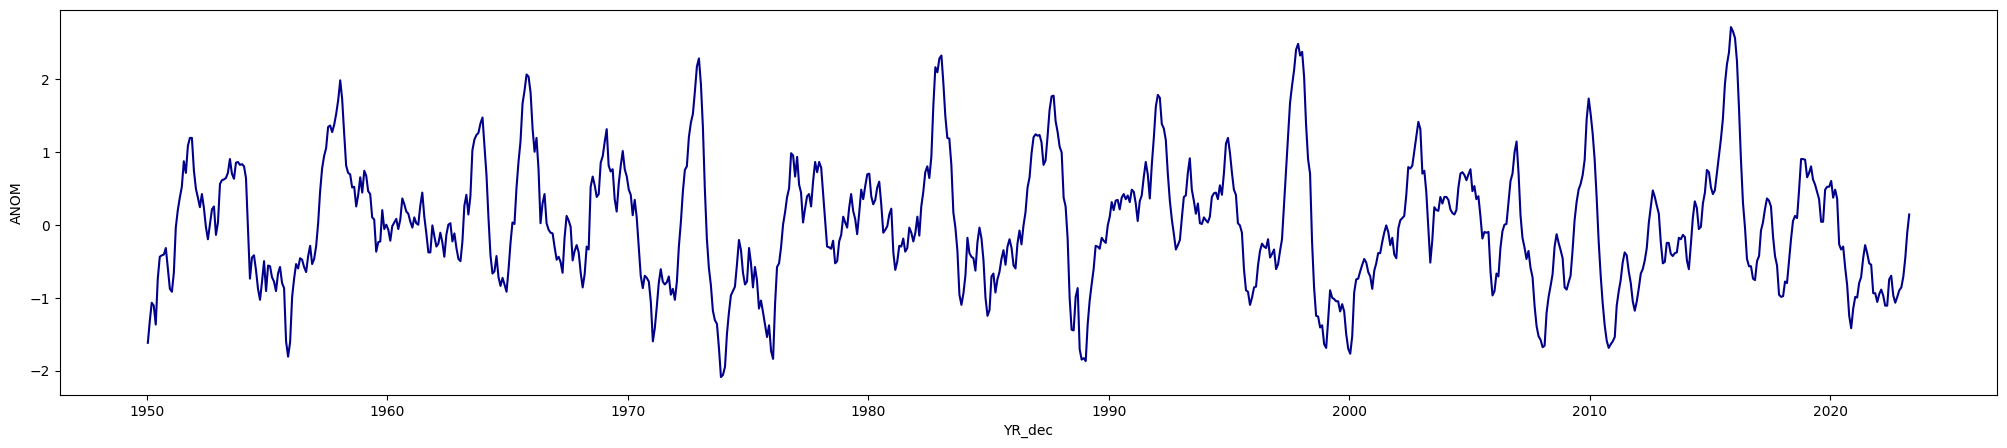

In [38]:
plt.figure(figsize=(25,5))
ax1 = sns.lineplot(data=df, x='YR_dec', y='ANOM', color='darkblue')
plt.show()

Agora vamos visualizar a mesma série, identificando os períodos de El Niño, La Niña, e incluindo a série temporal da atividade solar no mesmo gráfico, para ter uma imagem da situação em estudo.

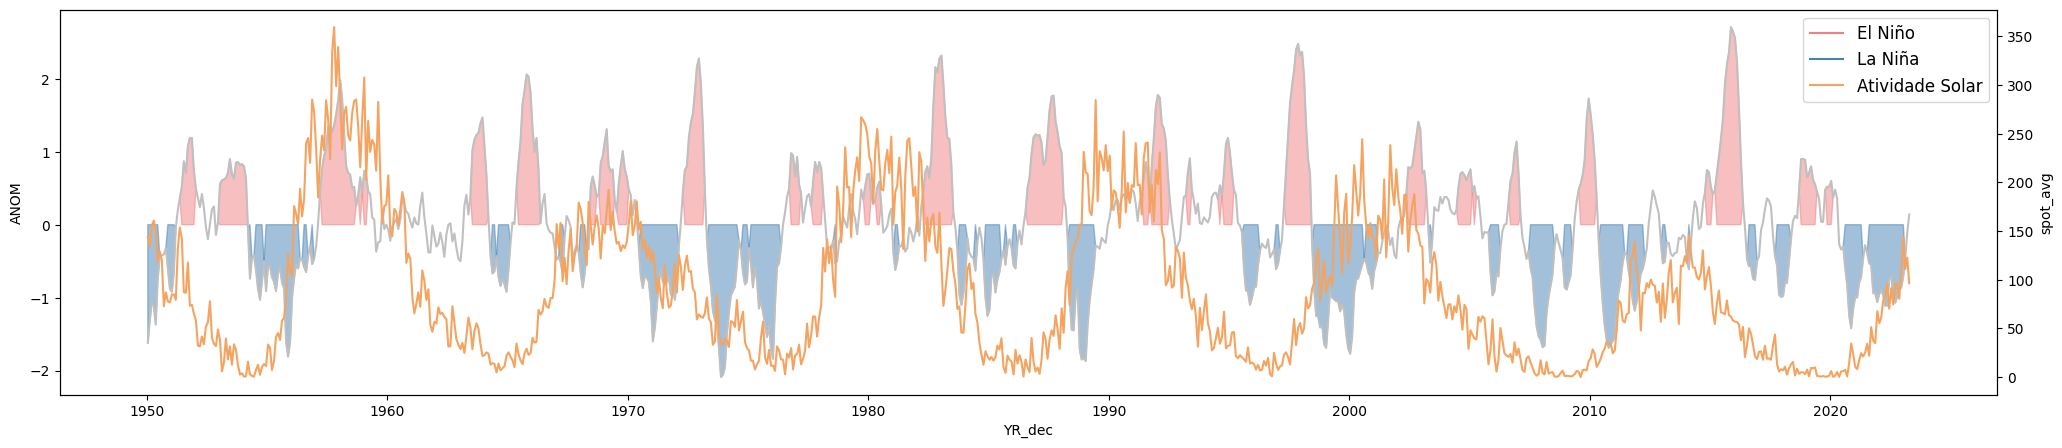

In [55]:
plt.figure(figsize=(25,5))

ax1 = sns.lineplot(data=df, x='YR_dec', y='ANOM', color='silver') #EL Niño

# Preenchimento
x_values = df['YR_dec']
y_values = df['ANOM']
plt.fill_between(x_values, y_values, 0, where=(y_values > 0.5), interpolate=True, alpha=0.5, color='lightcoral')
plt.fill_between(x_values, y_values, 0, where=(y_values < -0.5), interpolate=True, alpha=0.5, color='steelblue')

# Atividade Solar
ax2 = plt.twinx()
sns.lineplot(data=df, x='YR_dec', y='spot_avg', ax=ax2, color='sandybrown')

plt.legend(handles=[plt.Line2D([], [], color='lightcoral'), plt.Line2D([], [], color='steelblue'), plt.Line2D([], [], color='sandybrown')],
           labels=["El Niño", "La Niña", "Atividade Solar"], loc='best', prop={'size': 'large'})
plt.show()

### Lag features

Como essa análise consiste numa modelagem de séries temporais, é necessário criar lag features como variáveis.

Uma lag feature é uma variável derivada de valores anteriores de uma série temporal, utilizada como entrada em modelos de previsão. Essencialmente, ela representa o valor de uma variável em um ou mais momentos anteriores (lags), permitindo que o modelo capture padrões temporais, como tendências ou sazonalidades.

Após alguns testes, decidi por esses períodos: 1, 2, 3; 6, 9, 12; 24, 36, 48; sendo uma combinação de lags curtos(mensal), 
intermediários (de forma a capturar o padrão sazonal), e longos (possíveis padrões entre os anos).

In [60]:
df['ANOM_t-1'] = df['ANOM'].shift(1)
df['ANOM_t-2'] = df['ANOM'].shift(2)
df['ANOM_t-3'] = df['ANOM'].shift(3)
df['ANOM_t-6'] = df['ANOM'].shift(6)
df['ANOM_t-9'] = df['ANOM'].shift(9)
df['ANOM_t-12'] = df['ANOM'].shift(12)
df['ANOM_t-24'] = df['ANOM'].shift(24)
df['ANOM_t-36'] = df['ANOM'].shift(36)
df['ANOM_t-48'] = df['ANOM'].shift(48)

Defini então as variáveis independentes (X) e variável alvo (y). O alvo do estudo é a variável 'ANOM'.\
O conjunto X1 contém apenas as lag features, sem a atividade solar, e o conjunto X2 contém a atividade solar 'spot_avg' em adição às lag features. 

In [7]:
X1 = df[['ANOM_t-1', 'ANOM_t-2','ANOM_t-3', 'ANOM_t-6', 'ANOM_t-9', 'ANOM_t-12', 'ANOM_t-24', 'ANOM_t-36', 'ANOM_t-48']]
y = df['ANOM']

In [8]:
X2 = df[['spot_avg', 'ANOM_t-1', 'ANOM_t-2','ANOM_t-3', 'ANOM_t-6', 'ANOM_t-9', 'ANOM_t-12', 'ANOM_t-24', 'ANOM_t-36', 'ANOM_t-48']]


### Grid Search Cross-Validation

Para otimizar os hiperparâmetros dos modelos, realizei um Grid Search com validação cruzada, usando a base de lag features. As funções abaixo realizam o grid search e serão executadas em seguida. 

In [16]:
def perform_grid_search(X, y, cv=3):
    """
    Realiza Grid Search com validação cruzada para Random Forest e XGBoost.
    Retorna os melhores hiperparâmetros para cada modelo.
    """
    # Random Forest Grid Search
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestRegressor(random_state=44)
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=cv, scoring='neg_mean_squared_error')
    grid_search_rf.fit(X, y)
    best_params_rf = grid_search_rf.best_params_

    # XGBoost Grid Search
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.7, 0.8, 0.9]
    }
    xgb = XGBRegressor(random_state=44)
    grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=cv, scoring='neg_mean_squared_error')
    grid_search_xgb.fit(X, y)
    best_params_xgb = grid_search_xgb.best_params_

    return best_params_rf, best_params_xgb


In [17]:
best_params1_rf, best_params1_xgb = perform_grid_search(X1, y) #SEM ATIVIDADE SOLAR

Testei aplicar o Grid Search nas bases com e sem a atividade solar, e as diferenças nos hiperparâmetros foram desprezíveis. Utilizei então os hiperparâmetros determinados com a base SEM atividade solar. 

### Treinamento e Avaliação dos Modelos

Com os modelos bem configurados, agora é possível aplicá-los aos dados. A função abaixo treina os modelos de Random Forest e XGBoost nos dois conjuntos de dados (com e sem atividade solar)

In [24]:
def train_with_optimized_params(X, y, best_params_rf, best_params_xgb, test_size=0.25, random_state=44):
    """
    Treina e avalia Random Forest e XGBoost com os melhores hiperparâmetros encontrados.
    Também imprime os hiperparâmetros utilizados.
    """
    # Divide os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Treina e avalia os modelos otimizados

    # Random Forest Otimizado
    print("\nUsando os seguintes hiperparâmetros para Random Forest:")
    print(best_params_rf)
    rf_optimized = RandomForestRegressor(**best_params_rf, random_state=random_state)
    rf_optimized.fit(X_train, y_train)
    y_pred_rf = rf_optimized.predict(X_test)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # XGBoost Otimizado
    print("\nUsando os seguintes hiperparâmetros para XGBoost:")
    print(best_params_xgb)
    xgb_optimized = XGBRegressor(**best_params_xgb, random_state=random_state)
    xgb_optimized.fit(X_train, y_train)
    y_pred_xgb = xgb_optimized.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)

    # Retorna os resultados
    return {
        'results': pd.DataFrame({
            'Model': ['Random Forest', 'XGBoost'],
            'MSE': [mse_rf, mse_xgb],
            'R²': [r2_rf, r2_xgb]
        }),
        'y_test': y_test,
        'y_pred_rf': y_pred_rf,
        'y_pred_xgb': y_pred_xgb
    }


### Resultados

Agora aplicamos a função para os conjuntos X1 e X2 (o y é o mesmo):

In [31]:
# Sem atividade solar
results_X1 = train_with_optimized_params(X1, y, best_params1_rf, best_params1_xgb)
print(results_X1['results'])


Usando os seguintes hiperparâmetros para Random Forest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Usando os seguintes hiperparâmetros para XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
           Model       MSE        R²
0  Random Forest  0.065580  0.898676
1        XGBoost  0.065094  0.899427


In [32]:
# Com atividade solar
results_X2 = train_with_optimized_params(X2, y, best_params1_rf, best_params1_xgb)
print(results_X2['results'])


Usando os seguintes hiperparâmetros para Random Forest:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Usando os seguintes hiperparâmetros para XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
           Model       MSE        R²
0  Random Forest  0.066212  0.897698
1        XGBoost  0.065728  0.898447


### Visualização 

Abaixo coloquei a comparação visual dos valores preditos versus os valores reais para cada modelo, nos conjuntos X1 e X2. \

Relembrando:

X1 - sem atividade solar \
X2 - com atividade solar

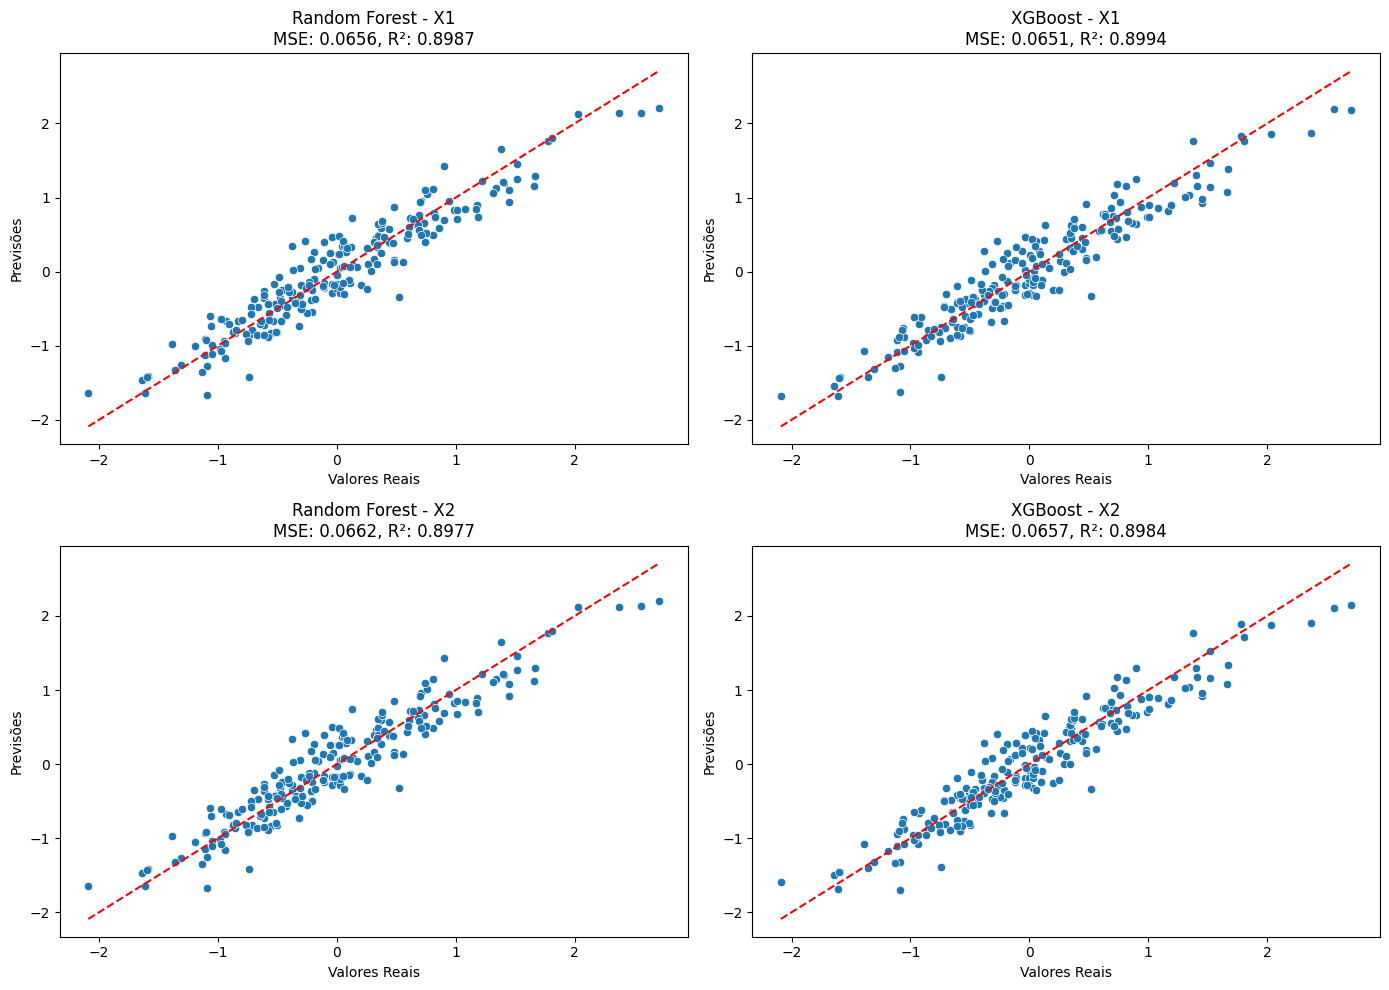

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Random Forest com X1
sns.scatterplot(x=results_X1['y_test'], y=results_X1['y_pred_rf'], ax=axs[0, 0])
axs[0, 0].plot([min(results_X1['y_test']), max(results_X1['y_test'])], [min(results_X1['y_test']), max(results_X1['y_test'])], color='red', linestyle='--')
axs[0, 0].set_title(f"Random Forest - X1\nMSE: {results_X1['results']['MSE'][0]:.4f}, R²: {results_X1['results']['R²'][0]:.4f}")

# Plot 2: XGBoost com X1
sns.scatterplot(x=results_X1['y_test'], y=results_X1['y_pred_xgb'], ax=axs[0, 1])
axs[0, 1].plot([min(results_X1['y_test']), max(results_X1['y_test'])], [min(results_X1['y_test']), max(results_X1['y_test'])], color='red', linestyle='--')
axs[0, 1].set_title(f"XGBoost - X1\nMSE: {results_X1['results']['MSE'][1]:.4f}, R²: {results_X1['results']['R²'][1]:.4f}")

# Plot 3: Random Forest com X2
sns.scatterplot(x=results_X2['y_test'], y=results_X2['y_pred_rf'], ax=axs[1, 0])
axs[1, 0].plot([min(results_X2['y_test']), max(results_X2['y_test'])], [min(results_X2['y_test']), max(results_X2['y_test'])], color='red', linestyle='--')
axs[1, 0].set_title(f"Random Forest - X2\nMSE: {results_X2['results']['MSE'][0]:.4f}, R²: {results_X2['results']['R²'][0]:.4f}")

# Plot 4: XGBoost com X2
sns.scatterplot(x=results_X2['y_test'], y=results_X2['y_pred_xgb'], ax=axs[1, 1])
axs[1, 1].plot([min(results_X2['y_test']), max(results_X2['y_test'])], [min(results_X2['y_test']), max(results_X2['y_test'])], color='red', linestyle='--')
axs[1, 1].set_title(f"XGBoost - X2\nMSE: {results_X2['results']['MSE'][1]:.4f}, R²: {results_X2['results']['R²'][1]:.4f}")


for ax in axs.flat:
    ax.set(xlabel='Valores Reais', ylabel='Previsões')

plt.tight_layout()
plt.show()

Como observado nos gráficos acima, as diferenças nas modelagens são muito sutis. Em números, o modelo do XGBoost sem a atividade solar foi o que apresentou maior R² (0.8994) e menor MSE (0.0651), sendo considerado tecnicamente como o melhor resultado. Porém as outras abordagens trazem resultados muito semelhantes. 

## Conclusões

Embora seja bem estabelecido que a atividade solar influencia o clima da Terra de maneira geral, os resultados deste projeto mostraram que, no contexto dos dados e modelos utilizados, a inclusão da variável de atividade solar (spot_avg) não resultou em melhorias significativas na capacidade preditiva dos modelos.

No entanto, essa observação não deve ser interpretada como uma ausência de influência da atividade solar sobre o clima global ou sobre o El Niño. Pelo contrário, a relação entre a atividade solar e o clima terrestre é complexa e multifacetada, operando em diferentes escalas temporais e interagindo com uma vasta gama de fatores climáticos e oceânicos. Os modelos utilizados neste projeto capturaram apenas uma parte dessas interações, e é possível que a influência da atividade solar seja mais sutil ou indireta, manifestando-se de maneiras que não foram totalmente capturadas pelos dados ou pela abordagem de modelagem adotada.

Além disso, o fato de os modelos terem identificado os mesmos hiperparâmetros ótimos, independentemente da inclusão ou exclusão da atividade solar, sugere que a modelagem é robusta e eficaz para o conjunto de dados analisado. Porém isso também indica que as nuances da interação entre a atividade solar e o El Niño requerem abordagens de modelagem mais sofisticadas.

Em conclusão, os resultados deste projeto mostram a complexidade do clima e a importância de continuar explorando o papel de múltiplos fatores interconectados, como a atividade solar, no comportamento do El Niño. Futuras investigações com modelos mais complexos e que capturem interações não lineares podem revelar mais sobre essa relação climática.

## Referências 

Dados do ENSO: https://www.cpc.ncep.noaa.gov/products/precip/CWlink/MJO/enso.shtml - NOAA/ National Weather Service \
https://en.wikipedia.org/wiki/El_Ni%C3%B1o%E2%80%93Southern_Oscillation \
https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/lanina/enso_evolution-status-fcsts-web.pdf \
Dados da atividade solar: https://www.sidc.be/SILSO/datafiles - Royal Observatory of Belgium \
https://www.swpc.noaa.gov/phenomena/sunspotssolar-cycle \
https://soho.nascom.nasa.gov/sunspots/ \
Lag Features: https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html \
Grid Search CV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

